In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Support Vector Machines library
from sklearn import svm

# Libraries to scale the data
from sklearn.preprocessing import StandardScaler

# Cross Validation
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

from sklearn.decomposition import PCA

# Bayesian Optimization libraries
from functools import partial
from skopt import gp_minimize
from skopt import space
from sklearn import model_selection

from sklearn import ensemble

# Performance Metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

# Ignores runtime warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

%matplotlib inline
plt.rcParams["figure.facecolor"] = 'w'

### Analysis on K-means Imputed and Outlier Presence dataset

In [2]:
df1 = pd.read_csv("../processed-datasets/data_outliers_handled_knn_imputed.csv")

In [3]:
df1.head()

,Unnamed: 0,age_ma,Feature,Ti,La,Ce,Pr,Nd,Sm,Eu,...,Dy,Ho,Er,Tm,Yb,Lu,Y,Hf,U,Th
0,0,222.0,0.0,7.88,0.050,10.500,0.050,4.25000,11.60000,1.99000,...,259.21625,106.1375,437.54375,97.8675,936.725,172.63875,2737.00000,12390.0,305.0,134.0
1,1,222.0,0.0,10.90,1.555,61.505,0.725,7.74125,12.56125,2.64375,...,259.21625,106.1375,437.54375,97.8675,936.725,172.63875,2804.03875,12591.0,503.0,272.0
2,2,222.0,0.0,6.00,0.020,25.100,0.300,4.41000,12.56125,2.30000,...,259.21625,106.1375,437.54375,97.8675,936.725,172.63875,2804.03875,12724.0,639.0,414.0
3,3,222.0,0.0,9.06,0.280,12.000,0.070,1.88000,5.08000,1.01000,...,194.00000,83.0000,356.00000,89.5000,762.000,144.00000,1832.00000,12894.0,308.0,127.0
4,4,222.0,0.0,4.93,0.070,16.500,0.150,2.32000,8.23000,1.52000,...,257.00000,106.1375,437.54375,97.8675,936.000,171.00000,2355.00000,12535.0,348.0,155.0


In [4]:
df1.drop('Unnamed: 0', axis=1, inplace=True)

In [5]:
df1.sample(5)

,age_ma,Feature,Ti,La,Ce,Pr,Nd,Sm,Eu,Gd,...,Dy,Ho,Er,Tm,Yb,Lu,Y,Hf,U,Th
1913,3.8,1.0,6.60,0.01,5.29,0.02,0.35,0.69,0.38,3.14,...,18.00,7.17,40.4,9.84,112.00,26.23,247.30,7350.00,44.60,27.4
1954,16.0,1.0,1.20,0.01,17.80,0.05,1.00,3.39,1.20,26.80,...,151.00,62.90,322.0,70.90,688.00,147.00,2420.00,10250.00,528.00,316.0
2569,370.0,1.0,3.44,0.07,5.40,0.05,0.72,1.23,0.78,6.71,...,31.76,13.97,85.3,24.38,331.31,64.79,511.25,6999.07,65.04,29.5
2002,36.0,1.0,3.80,0.04,14.30,0.02,0.39,0.88,0.45,6.14,...,31.30,14.00,81.1,21.30,252.00,64.00,489.00,10693.00,313.00,249.0
640,254.0,0.0,11.60,0.01,1.02,0.03,1.02,2.97,0.07,23.10,...,134.00,55.00,254.0,56.60,525.00,90.20,1631.00,12496.00,208.00,58.5


In [6]:
X = df1.drop('Feature', axis=1).values
y = df1.Feature.values.astype(int)

### Splitting the dataset

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

### Scaling the data using Standard Scaler

In [8]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
X_train_scaled.shape

(2390, 20)

### Fitting the base model of SVM

In [10]:
svm_base = svm.SVC()

In [11]:
svm_base.fit(X_train_scaled, y_train)

SVC()

In [12]:
y_pred = svm_base.predict(X_test_scaled)

In [13]:
print("Accuracy of test set on base model: ", round(accuracy_score(y_test, y_pred), 2))

Accuracy of test set on base model:  0.91


In [14]:
print("Classification report of test set: \n\n", classification_report(y_test, y_pred))

Classification report of test set: 

               precision    recall  f1-score   support

           0       0.95      0.89      0.92       341
           1       0.86      0.94      0.90       257

    accuracy                           0.91       598
   macro avg       0.91      0.91      0.91       598
weighted avg       0.91      0.91      0.91       598



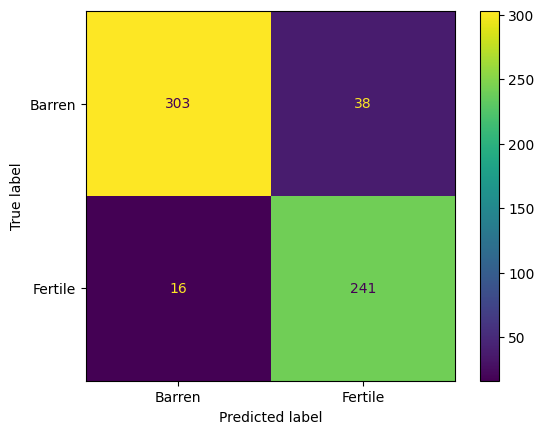

In [15]:
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(cm, display_labels=['Barren', 'Fertile']).plot()

### Hyper-parameter tuning

### Grid Search Optimization with stratified K-fold Cross Validation

In [16]:
Stratified_kf = StratifiedKFold(n_splits=10, shuffle=True)

In [17]:
param_grid = {
    'C': np.arange(0, 6, 1),
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [3, 4],
    'gamma': ['scale', 'auto']
}

In [18]:
clf = GridSearchCV(estimator = svm.SVC(), cv = Stratified_kf, param_grid = param_grid, 
                   n_jobs = -1, verbose = 10, return_train_score = True)

In [19]:
clf.fit(X_train_scaled, y_train)

Fitting 10 folds for each of 96 candidates, totalling 960 fits
[CV 1/10; 1/96] START C=0, degree=3, gamma=scale, kernel=linear.................
[CV 1/10; 1/96] END C=0, degree=3, gamma=scale, kernel=linear;, score=(train=nan, test=nan) total time=   0.0s
[CV 9/10; 1/96] START C=0, degree=3, gamma=scale, kernel=linear.................
[CV 9/10; 1/96] END C=0, degree=3, gamma=scale, kernel=linear;, score=(train=nan, test=nan) total time=   0.0s
[CV 10/10; 1/96] START C=0, degree=3, gamma=scale, kernel=linear................
[CV 10/10; 1/96] END C=0, degree=3, gamma=scale, kernel=linear;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/10; 2/96] START C=0, degree=3, gamma=scale, kernel=poly...................
[CV 1/10; 2/96] END C=0, degree=3, gamma=scale, kernel=poly;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/10; 2/96] START C=0, degree=3, gamma=scale, kernel=poly...................
[CV 2/10; 2/96] END C=0, degree=3, gamma=scale, kernel=poly;, score=(train=nan, test=nan)

[CV 4/10; 1/96] START C=0, degree=3, gamma=scale, kernel=linear.................
[CV 4/10; 1/96] END C=0, degree=3, gamma=scale, kernel=linear;, score=(train=nan, test=nan) total time=   0.0s
[CV 7/10; 7/96] START C=0, degree=3, gamma=auto, kernel=rbf.....................
[CV 7/10; 7/96] END C=0, degree=3, gamma=auto, kernel=rbf;, score=(train=nan, test=nan) total time=   0.0s
[CV 8/10; 7/96] START C=0, degree=3, gamma=auto, kernel=rbf.....................
[CV 8/10; 7/96] END C=0, degree=3, gamma=auto, kernel=rbf;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/10; 8/96] START C=0, degree=3, gamma=auto, kernel=sigmoid.................
[CV 1/10; 8/96] END C=0, degree=3, gamma=auto, kernel=sigmoid;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/10; 8/96] START C=0, degree=3, gamma=auto, kernel=sigmoid.................
[CV 2/10; 8/96] END C=0, degree=3, gamma=auto, kernel=sigmoid;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/10; 10/96] START C=0, degree=4, gamma=scal

[CV 7/10; 1/96] START C=0, degree=3, gamma=scale, kernel=linear.................
[CV 7/10; 1/96] END C=0, degree=3, gamma=scale, kernel=linear;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/10; 7/96] START C=0, degree=3, gamma=auto, kernel=rbf.....................
[CV 1/10; 7/96] END C=0, degree=3, gamma=auto, kernel=rbf;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/10; 7/96] START C=0, degree=3, gamma=auto, kernel=rbf.....................
[CV 2/10; 7/96] END C=0, degree=3, gamma=auto, kernel=rbf;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/10; 7/96] START C=0, degree=3, gamma=auto, kernel=rbf.....................
[CV 5/10; 7/96] END C=0, degree=3, gamma=auto, kernel=rbf;, score=(train=nan, test=nan) total time=   0.0s
[CV 6/10; 7/96] START C=0, degree=3, gamma=auto, kernel=rbf.....................
[CV 6/10; 7/96] END C=0, degree=3, gamma=auto, kernel=rbf;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/10; 8/96] START C=0, degree=3, gamma=auto, kernel=

/opt/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
160 fits failed out of a total of 960.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
160 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/miniconda3/lib/python3.9/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/opt/miniconda3/lib/python3.9/site-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/opt/miniconda3/lib/python3.9/site-p

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=SVC(), n_jobs=-1,
             param_grid={'C': array([0, 1, 2, 3, 4, 5]), 'degree': [3, 4],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             return_train_score=True, verbose=10)

In [20]:
clf.best_estimator_

SVC(C=5)

In [21]:
best_params = clf.best_params_

In [22]:
round(clf.best_score_, 2)

0.94

In [23]:
best_model_svc = svm.SVC(**best_params)

In [24]:
best_model_svc.fit(X_train_scaled, y_train)

SVC(C=5)

In [25]:
y_pred_best = best_model_svc.predict(X_test_scaled)

In [26]:
print("Accuracy of tuned model over test set: ", round(accuracy_score(y_test, y_pred_best), 2))

Accuracy of tuned model over test set:  0.94


In [27]:
print("Classification report of test set: \n\n", classification_report(y_test, y_pred_best))

Classification report of test set: 

               precision    recall  f1-score   support

           0       0.97      0.92      0.94       341
           1       0.90      0.96      0.93       257

    accuracy                           0.94       598
   macro avg       0.94      0.94      0.94       598
weighted avg       0.94      0.94      0.94       598



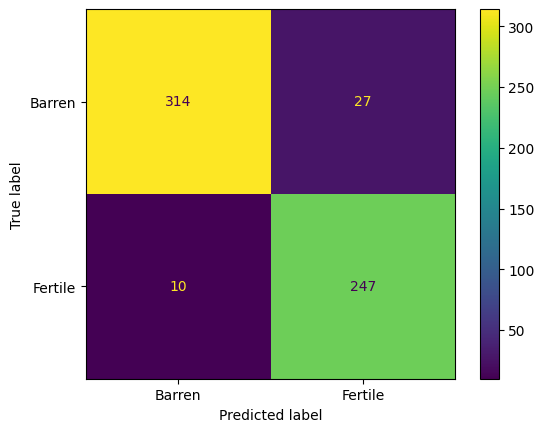

In [28]:
cm = confusion_matrix(y_test, y_pred_best)

ConfusionMatrixDisplay(cm, display_labels=['Barren', 'Fertile']).plot()

### Plotting the decision boundary

In [29]:
input_features = X_test_scaled.copy()
output_feature = y_test.copy()

In [30]:
pca = PCA(n_components = 2)

X_reduced = pca.fit_transform(input_features)

In [31]:
X_reduced.shape

(598, 2)

In [32]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

In [33]:
def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [34]:
plot_model = svm.SVC(**best_params)

plot_model.fit(X_reduced, output_feature)

SVC(C=5)

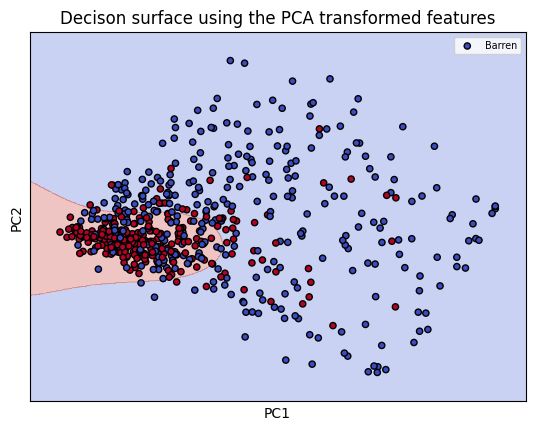

In [35]:
fig, ax = plt.subplots(facecolor='white')

# title for the plots
title = ('Decision surface of Tuned SVC ')

# Set-up grid for plotting.
X0, X1 = X_reduced[:, 0], X_reduced[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, plot_model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.3) # alpha=0.8
ax.scatter(X0, X1, c=y_test, edgecolors='k', cmap=plt.cm.coolwarm, s=20)
ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title('Decison surface using the PCA transformed features')
ax.legend(labels=['Barren', 'Fertile'], fontsize="x-small")
plt.show()